In [20]:
import random
import gym
import numpy as np
from collections import deque
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Conv1D, MaxPooling1D, Flatten, Dropout
from keras.optimizers import Adam
from keras import backend as K
print(K.tensorflow_backend._get_available_gpus())
from IPython.display import display, clear_output
import random
from sklearn import preprocessing


['/job:localhost/replica:0/task:0/device:GPU:0']


In [25]:
# Deep Q-learning Agent
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen = 11110)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999
        self.model = self._build_model()
        self.walk = deque(maxlen = 900)
        
    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(300, input_dim=self.state_size, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))
        
        model.add(Dense(300, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))
        
        model.add(Dense(300, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))
        
        
        model.add(Dense(300, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))
        
        
        model.add(Dense(100, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))
        
        model.add(Dense(self.action_size, activation='tanh'))
        
        model.compile(loss='mse', optimizer=Adam())
#         model.summary()
        return model
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return (np.random.rand(4) * 2) -1
        
        act_values = 0
        act_values = self.model.predict(state)
            
        act_values = [item for sublist in act_values for item in sublist]
        return act_values # returns action
    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.gamma * self.model.predict(next_state)[0]
            
            target_f = self.model.predict(state)
            
            target_f[:] = target
            self.model.fit(state, target_f, epochs= 1, verbose=0 )
                
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        random.shuffle(self.memory)
        
        
        if np.random.rand() > 0.8:
            self.memory.pop()

        

    def save_model(self):
        self.model.save('./checkpoint.h5')
    def load_model(self):
        self.model.load_weights('./checkpoint.h5')

In [26]:
def count_consec_300(x):
    cnt = 0
    for i in range(len(x)):
        if x[i] >= 300:
            cnt += 1
        else:
            cnt = 0
    return cnt

def reward_greater(rew, no_improve):
    if rew < 0:
        no_improve += 1
    else:
        no_improve = 0
    return no_improve

In [27]:

env = gym.make('BipedalWalker-v2')
state_size = 24
action_size = 4
agent = DQNAgent(state_size, action_size)
# agent.load_model()
done = False
batch_size = 64
game_history = [0]
t_steps = 0
for e in range(100000):
    state = env.reset()
    state = np.reshape(state, [1, state_size])
    prev_reward = 0
    no_improve = 0
    total_reward = 0
    for time in range(450):
        # env.render()
#         if time % 5 == 0:
#             print(time, end=', ')
        

        
        action = agent.act(state)
        
        next_state, reward, done, _ = env.step(action)
        no_improve = reward_greater(reward , no_improve)
        if done or  no_improve == 5:
            done = True
            reward = -100
#         print("diff:", reward - prev_reward,"prev:", prev_reward, " current:", reward)

        next_state = np.reshape(next_state, [1, state_size])
        if len(agent.memory) < 10000 and reward > 0:
            agent.remember(state, action, reward, next_state, done)
        elif reward > 0:
            agent.remember(state, action, reward, next_state, done)
        state = next_state
        
        if done:
            break
        
        prev_reward = reward
        total_reward += reward
        if len(agent.memory) > 10000:
            agent.replay(batch_size)
    
#     game_history.append(total_reward)
    if e % 10 == 4:
        print("round:{} score: {}, count 300:{} max:{} min:{} mean:{}, len_pos:{}".format(e, total_reward ,count_consec_300(game_history), max(game_history), min(game_history), np.mean(game_history), len(agent.memory)))

    done = False

#         agent.save_model()
np.save("positive_scene",agent.memory)

round:4 score: -0.9661609079389498, count 300:0 max:0 min:0 mean:0.0, len_pos:2
round:14 score: -0.43237898724552526, count 300:0 max:0 min:0 mean:0.0, len_pos:2
round:24 score: -0.40006880182859994, count 300:0 max:0 min:0 mean:0.0, len_pos:8
round:34 score: -0.36355165177051174, count 300:0 max:0 min:0 mean:0.0, len_pos:8
round:44 score: -0.4072605223779478, count 300:0 max:0 min:0 mean:0.0, len_pos:10
round:54 score: -0.7699411790602545, count 300:0 max:0 min:0 mean:0.0, len_pos:14
round:64 score: -0.46498248959152566, count 300:0 max:0 min:0 mean:0.0, len_pos:16
round:74 score: -0.775281114282564, count 300:0 max:0 min:0 mean:0.0, len_pos:17
round:84 score: -0.5412840554600179, count 300:0 max:0 min:0 mean:0.0, len_pos:17
round:94 score: -0.5837979438375269, count 300:0 max:0 min:0 mean:0.0, len_pos:17
round:104 score: -1.0139424936881254, count 300:0 max:0 min:0 mean:0.0, len_pos:19
round:114 score: -1.0966123784405468, count 300:0 max:0 min:0 mean:0.0, len_pos:21
round:124 score:

round:1004 score: -0.8911914998738929, count 300:0 max:0 min:0 mean:0.0, len_pos:234
round:1014 score: -0.5375945235931129, count 300:0 max:0 min:0 mean:0.0, len_pos:235
round:1024 score: -0.5599465580344674, count 300:0 max:0 min:0 mean:0.0, len_pos:237
round:1034 score: -0.7018749300948776, count 300:0 max:0 min:0 mean:0.0, len_pos:240
round:1044 score: -0.4504040393610839, count 300:0 max:0 min:0 mean:0.0, len_pos:242
round:1054 score: -0.4621887883778062, count 300:0 max:0 min:0 mean:0.0, len_pos:244
round:1064 score: -0.553100987933782, count 300:0 max:0 min:0 mean:0.0, len_pos:245
round:1074 score: -0.29018128670720744, count 300:0 max:0 min:0 mean:0.0, len_pos:251
round:1084 score: -0.28536480895120736, count 300:0 max:0 min:0 mean:0.0, len_pos:252
round:1094 score: -0.44589697239384385, count 300:0 max:0 min:0 mean:0.0, len_pos:254
round:1104 score: -0.44082358178256487, count 300:0 max:0 min:0 mean:0.0, len_pos:259
round:1114 score: -0.24119090381038316, count 300:0 max:0 min:

round:2004 score: -1.438773248151052, count 300:0 max:0 min:0 mean:0.0, len_pos:467
round:2014 score: -0.23083444674174175, count 300:0 max:0 min:0 mean:0.0, len_pos:468
round:2024 score: -0.6334483339144534, count 300:0 max:0 min:0 mean:0.0, len_pos:472
round:2034 score: -0.17431304053193766, count 300:0 max:0 min:0 mean:0.0, len_pos:472
round:2044 score: -0.34672074543834763, count 300:0 max:0 min:0 mean:0.0, len_pos:475
round:2054 score: -0.6936061078166422, count 300:0 max:0 min:0 mean:0.0, len_pos:476
round:2064 score: -0.8297974073256321, count 300:0 max:0 min:0 mean:0.0, len_pos:477
round:2074 score: -0.40428844394563346, count 300:0 max:0 min:0 mean:0.0, len_pos:479
round:2084 score: -0.2212958572011201, count 300:0 max:0 min:0 mean:0.0, len_pos:480
round:2094 score: -0.3489405686342337, count 300:0 max:0 min:0 mean:0.0, len_pos:480
round:2104 score: -0.5118381152003737, count 300:0 max:0 min:0 mean:0.0, len_pos:480
round:2114 score: -0.5899327852537875, count 300:0 max:0 min:0

round:3004 score: -0.8426979117975077, count 300:0 max:0 min:0 mean:0.0, len_pos:672
round:3014 score: -0.8508371037153362, count 300:0 max:0 min:0 mean:0.0, len_pos:672
round:3024 score: -0.360499568766163, count 300:0 max:0 min:0 mean:0.0, len_pos:675
round:3034 score: -0.6619005549511101, count 300:0 max:0 min:0 mean:0.0, len_pos:677
round:3044 score: -0.38700428438085777, count 300:0 max:0 min:0 mean:0.0, len_pos:680
round:3054 score: -0.33522360711797095, count 300:0 max:0 min:0 mean:0.0, len_pos:680
round:3064 score: -0.4725284753571577, count 300:0 max:0 min:0 mean:0.0, len_pos:682
round:3074 score: -0.35851852088804814, count 300:0 max:0 min:0 mean:0.0, len_pos:686
round:3084 score: -0.6145587725484362, count 300:0 max:0 min:0 mean:0.0, len_pos:686
round:3094 score: -0.60087045650677, count 300:0 max:0 min:0 mean:0.0, len_pos:686
round:3104 score: -0.5762247849483569, count 300:0 max:0 min:0 mean:0.0, len_pos:690
round:3114 score: -0.3164545314120875, count 300:0 max:0 min:0 me

round:4004 score: -0.5281598009991357, count 300:0 max:0 min:0 mean:0.0, len_pos:869
round:4014 score: -0.3929102072410664, count 300:0 max:0 min:0 mean:0.0, len_pos:876
round:4024 score: -0.7457734611061966, count 300:0 max:0 min:0 mean:0.0, len_pos:877
round:4034 score: -0.5563634601472867, count 300:0 max:0 min:0 mean:0.0, len_pos:883
round:4044 score: -0.43250782515214437, count 300:0 max:0 min:0 mean:0.0, len_pos:883
round:4054 score: -0.6065222391540577, count 300:0 max:0 min:0 mean:0.0, len_pos:889
round:4064 score: -0.543528273964435, count 300:0 max:0 min:0 mean:0.0, len_pos:892
round:4074 score: -0.3896890151614105, count 300:0 max:0 min:0 mean:0.0, len_pos:895
round:4084 score: -0.17993618862789482, count 300:0 max:0 min:0 mean:0.0, len_pos:897
round:4094 score: -0.5229666514970093, count 300:0 max:0 min:0 mean:0.0, len_pos:898
round:4104 score: -0.5489872685045794, count 300:0 max:0 min:0 mean:0.0, len_pos:900
round:4114 score: -0.750835903987148, count 300:0 max:0 min:0 me

round:4964 score: -0.8060720933447553, count 300:0 max:0 min:0 mean:0.0, len_pos:1100
round:4974 score: -0.5244994545756402, count 300:0 max:0 min:0 mean:0.0, len_pos:1100
round:4984 score: -0.8025955185891702, count 300:0 max:0 min:0 mean:0.0, len_pos:1108
round:4994 score: -0.258519255546035, count 300:0 max:0 min:0 mean:0.0, len_pos:1109
round:5004 score: -0.2633197753147217, count 300:0 max:0 min:0 mean:0.0, len_pos:1112
round:5014 score: -0.4668359116953849, count 300:0 max:0 min:0 mean:0.0, len_pos:1112
round:5024 score: -0.559022101499316, count 300:0 max:0 min:0 mean:0.0, len_pos:1112
round:5034 score: -0.595404667634275, count 300:0 max:0 min:0 mean:0.0, len_pos:1114
round:5044 score: -0.4393639671451315, count 300:0 max:0 min:0 mean:0.0, len_pos:1118
round:5054 score: -0.27547870365743615, count 300:0 max:0 min:0 mean:0.0, len_pos:1118
round:5064 score: -0.3499502285359481, count 300:0 max:0 min:0 mean:0.0, len_pos:1120
round:5074 score: -0.50695882379862, count 300:0 max:0 m

round:5924 score: -0.5300838082373756, count 300:0 max:0 min:0 mean:0.0, len_pos:1283
round:5934 score: -0.3679203112141097, count 300:0 max:0 min:0 mean:0.0, len_pos:1286
round:5944 score: -0.5033509811016377, count 300:0 max:0 min:0 mean:0.0, len_pos:1289
round:5954 score: -0.6109850458075607, count 300:0 max:0 min:0 mean:0.0, len_pos:1291
round:5964 score: -0.4611061658049836, count 300:0 max:0 min:0 mean:0.0, len_pos:1291
round:5974 score: -0.45815357534095247, count 300:0 max:0 min:0 mean:0.0, len_pos:1294
round:5984 score: -0.6978751955542748, count 300:0 max:0 min:0 mean:0.0, len_pos:1298
round:5994 score: -0.5146632396106419, count 300:0 max:0 min:0 mean:0.0, len_pos:1299
round:6004 score: -0.5319298374279978, count 300:0 max:0 min:0 mean:0.0, len_pos:1304
round:6014 score: -0.6906913310038694, count 300:0 max:0 min:0 mean:0.0, len_pos:1307
round:6024 score: -0.5904463969805159, count 300:0 max:0 min:0 mean:0.0, len_pos:1311
round:6034 score: -0.3199260118683449, count 300:0 ma

round:6884 score: -0.898066199645889, count 300:0 max:0 min:0 mean:0.0, len_pos:1478
round:6894 score: -0.6118397559065955, count 300:0 max:0 min:0 mean:0.0, len_pos:1478
round:6904 score: -0.3920602569993019, count 300:0 max:0 min:0 mean:0.0, len_pos:1479
round:6914 score: -0.5667032084314627, count 300:0 max:0 min:0 mean:0.0, len_pos:1480
round:6924 score: -0.42637116993091595, count 300:0 max:0 min:0 mean:0.0, len_pos:1481
round:6934 score: -0.5095226733762495, count 300:0 max:0 min:0 mean:0.0, len_pos:1485
round:6944 score: -0.4655728480735041, count 300:0 max:0 min:0 mean:0.0, len_pos:1485
round:6954 score: -0.5606723480276482, count 300:0 max:0 min:0 mean:0.0, len_pos:1485
round:6964 score: -0.3967655011239383, count 300:0 max:0 min:0 mean:0.0, len_pos:1489
round:6974 score: -0.8622111092953525, count 300:0 max:0 min:0 mean:0.0, len_pos:1490
round:6984 score: -0.40801263897583745, count 300:0 max:0 min:0 mean:0.0, len_pos:1492
round:6994 score: -0.38799096539929695, count 300:0 m

round:7844 score: -0.6464208225917728, count 300:0 max:0 min:0 mean:0.0, len_pos:1706
round:7854 score: -0.71433811372096, count 300:0 max:0 min:0 mean:0.0, len_pos:1706
round:7864 score: -0.8493157028054905, count 300:0 max:0 min:0 mean:0.0, len_pos:1707
round:7874 score: -0.25881138461105224, count 300:0 max:0 min:0 mean:0.0, len_pos:1709
round:7884 score: -0.9282640541115137, count 300:0 max:0 min:0 mean:0.0, len_pos:1713
round:7894 score: -0.4265144541468332, count 300:0 max:0 min:0 mean:0.0, len_pos:1715
round:7904 score: -0.4006093527380269, count 300:0 max:0 min:0 mean:0.0, len_pos:1715
round:7914 score: -0.5037713063837542, count 300:0 max:0 min:0 mean:0.0, len_pos:1715
round:7924 score: -0.33023892891006396, count 300:0 max:0 min:0 mean:0.0, len_pos:1716
round:7934 score: -0.7359561801249874, count 300:0 max:0 min:0 mean:0.0, len_pos:1719
round:7944 score: -0.3032998764005034, count 300:0 max:0 min:0 mean:0.0, len_pos:1722
round:7954 score: -0.5376990218814292, count 300:0 max

round:8804 score: -0.29205730113752876, count 300:0 max:0 min:0 mean:0.0, len_pos:1937
round:8814 score: -0.8001269735619794, count 300:0 max:0 min:0 mean:0.0, len_pos:1938
round:8824 score: -0.3308102621708473, count 300:0 max:0 min:0 mean:0.0, len_pos:1939
round:8834 score: -0.490065049865264, count 300:0 max:0 min:0 mean:0.0, len_pos:1941
round:8844 score: -0.25778720750721085, count 300:0 max:0 min:0 mean:0.0, len_pos:1941
round:8854 score: -0.5049398919470525, count 300:0 max:0 min:0 mean:0.0, len_pos:1941
round:8864 score: -0.7418249190318094, count 300:0 max:0 min:0 mean:0.0, len_pos:1941
round:8874 score: -0.39964252167446734, count 300:0 max:0 min:0 mean:0.0, len_pos:1944
round:8884 score: -0.44800057350789974, count 300:0 max:0 min:0 mean:0.0, len_pos:1945
round:8894 score: -0.30404483287972184, count 300:0 max:0 min:0 mean:0.0, len_pos:1946
round:8904 score: -0.3126647436500324, count 300:0 max:0 min:0 mean:0.0, len_pos:1947
round:8914 score: -0.514746429097446, count 300:0 

round:9764 score: -0.8069417217790658, count 300:0 max:0 min:0 mean:0.0, len_pos:2159
round:9774 score: -0.43542620526456965, count 300:0 max:0 min:0 mean:0.0, len_pos:2162
round:9784 score: -0.5750089591130413, count 300:0 max:0 min:0 mean:0.0, len_pos:2162
round:9794 score: -0.6752442991060144, count 300:0 max:0 min:0 mean:0.0, len_pos:2163
round:9804 score: -0.7439298146644202, count 300:0 max:0 min:0 mean:0.0, len_pos:2167
round:9814 score: -0.8348069240116466, count 300:0 max:0 min:0 mean:0.0, len_pos:2168
round:9824 score: -0.5499956391041233, count 300:0 max:0 min:0 mean:0.0, len_pos:2168
round:9834 score: -0.4327726616369191, count 300:0 max:0 min:0 mean:0.0, len_pos:2169
round:9844 score: -0.7489658038224577, count 300:0 max:0 min:0 mean:0.0, len_pos:2170
round:9854 score: -0.33259955000875174, count 300:0 max:0 min:0 mean:0.0, len_pos:2175
round:9864 score: -0.4569671802758396, count 300:0 max:0 min:0 mean:0.0, len_pos:2178
round:9874 score: -0.6616457265239383, count 300:0 m

round:10724 score: -0.31134795867710763, count 300:0 max:0 min:0 mean:0.0, len_pos:2350
round:10734 score: -0.6312435566591906, count 300:0 max:0 min:0 mean:0.0, len_pos:2352
round:10744 score: -0.6722805574888577, count 300:0 max:0 min:0 mean:0.0, len_pos:2356
round:10754 score: -0.3743309014119672, count 300:0 max:0 min:0 mean:0.0, len_pos:2358
round:10764 score: -0.6705061299638609, count 300:0 max:0 min:0 mean:0.0, len_pos:2358
round:10774 score: -0.3701380077706333, count 300:0 max:0 min:0 mean:0.0, len_pos:2358
round:10784 score: -0.5277970914907562, count 300:0 max:0 min:0 mean:0.0, len_pos:2358
round:10794 score: -0.33818078496570153, count 300:0 max:0 min:0 mean:0.0, len_pos:2358
round:10804 score: -0.667227124171476, count 300:0 max:0 min:0 mean:0.0, len_pos:2360
round:10814 score: -0.31024523533761195, count 300:0 max:0 min:0 mean:0.0, len_pos:2362
round:10824 score: -0.5745284289744581, count 300:0 max:0 min:0 mean:0.0, len_pos:2366
round:10834 score: -1.0201832901866104, c

round:11684 score: -0.40337314581580747, count 300:0 max:0 min:0 mean:0.0, len_pos:2571
round:11694 score: -0.6387604098255611, count 300:0 max:0 min:0 mean:0.0, len_pos:2572
round:11704 score: -1.0188152888752016, count 300:0 max:0 min:0 mean:0.0, len_pos:2572
round:11714 score: -0.2834825359372149, count 300:0 max:0 min:0 mean:0.0, len_pos:2573
round:11724 score: -0.46696425503806394, count 300:0 max:0 min:0 mean:0.0, len_pos:2573
round:11734 score: -0.323187015314221, count 300:0 max:0 min:0 mean:0.0, len_pos:2574
round:11744 score: -0.3889347823898947, count 300:0 max:0 min:0 mean:0.0, len_pos:2577
round:11754 score: -0.36868864855906747, count 300:0 max:0 min:0 mean:0.0, len_pos:2579
round:11764 score: -0.2794312771602593, count 300:0 max:0 min:0 mean:0.0, len_pos:2580
round:11774 score: -0.6973849709496478, count 300:0 max:0 min:0 mean:0.0, len_pos:2582
round:11784 score: -0.34662782180511, count 300:0 max:0 min:0 mean:0.0, len_pos:2585
round:11794 score: -0.4596679681547696, cou

round:12634 score: -0.392607778401588, count 300:0 max:0 min:0 mean:0.0, len_pos:2786
round:12644 score: -0.5396729510576218, count 300:0 max:0 min:0 mean:0.0, len_pos:2790
round:12654 score: -0.4140517671278601, count 300:0 max:0 min:0 mean:0.0, len_pos:2792
round:12664 score: -0.4838230723644199, count 300:0 max:0 min:0 mean:0.0, len_pos:2792
round:12674 score: -0.524550335647074, count 300:0 max:0 min:0 mean:0.0, len_pos:2794
round:12684 score: -0.38486607418766383, count 300:0 max:0 min:0 mean:0.0, len_pos:2796
round:12694 score: -0.7963033969581734, count 300:0 max:0 min:0 mean:0.0, len_pos:2798
round:12704 score: -0.32946583244961425, count 300:0 max:0 min:0 mean:0.0, len_pos:2798
round:12714 score: -0.31621295128622884, count 300:0 max:0 min:0 mean:0.0, len_pos:2798
round:12724 score: -0.6162371499092207, count 300:0 max:0 min:0 mean:0.0, len_pos:2798
round:12734 score: -0.6492360628968374, count 300:0 max:0 min:0 mean:0.0, len_pos:2809
round:12744 score: -0.8798593698228907, co

round:13594 score: -0.6483171116303903, count 300:0 max:0 min:0 mean:0.0, len_pos:2999
round:13604 score: -0.4601696099042143, count 300:0 max:0 min:0 mean:0.0, len_pos:2999
round:13614 score: -0.3351365179306228, count 300:0 max:0 min:0 mean:0.0, len_pos:3005
round:13624 score: -0.9041717816048168, count 300:0 max:0 min:0 mean:0.0, len_pos:3007
round:13634 score: -0.689159728578322, count 300:0 max:0 min:0 mean:0.0, len_pos:3007
round:13644 score: -0.8827474695771368, count 300:0 max:0 min:0 mean:0.0, len_pos:3014
round:13654 score: -0.5225213250186872, count 300:0 max:0 min:0 mean:0.0, len_pos:3015
round:13664 score: -0.3337697867218649, count 300:0 max:0 min:0 mean:0.0, len_pos:3016
round:13674 score: -0.32111270713445783, count 300:0 max:0 min:0 mean:0.0, len_pos:3018
round:13684 score: -0.5191032955200062, count 300:0 max:0 min:0 mean:0.0, len_pos:3019
round:13694 score: -0.4254579208432404, count 300:0 max:0 min:0 mean:0.0, len_pos:3023
round:13704 score: -0.4803222698614481, cou

round:14554 score: -0.35022550218885845, count 300:0 max:0 min:0 mean:0.0, len_pos:3213
round:14564 score: -0.4994700817790953, count 300:0 max:0 min:0 mean:0.0, len_pos:3214
round:14574 score: -0.3705137899384213, count 300:0 max:0 min:0 mean:0.0, len_pos:3214
round:14584 score: -0.373236845850732, count 300:0 max:0 min:0 mean:0.0, len_pos:3219
round:14594 score: -0.526865804754114, count 300:0 max:0 min:0 mean:0.0, len_pos:3223
round:14604 score: -0.8243061353263561, count 300:0 max:0 min:0 mean:0.0, len_pos:3227
round:14614 score: -0.7457686901439387, count 300:0 max:0 min:0 mean:0.0, len_pos:3230
round:14624 score: -0.3757380949005339, count 300:0 max:0 min:0 mean:0.0, len_pos:3235
round:14634 score: -0.4821235871158049, count 300:0 max:0 min:0 mean:0.0, len_pos:3237
round:14644 score: -0.7320051033127295, count 300:0 max:0 min:0 mean:0.0, len_pos:3241
round:14654 score: -0.8756649114277264, count 300:0 max:0 min:0 mean:0.0, len_pos:3242
round:14664 score: -0.2872429874445604, coun

round:15514 score: -0.7891807563481942, count 300:0 max:0 min:0 mean:0.0, len_pos:3397
round:15524 score: -0.8479991411176906, count 300:0 max:0 min:0 mean:0.0, len_pos:3405
round:15534 score: -1.0792203612162503, count 300:0 max:0 min:0 mean:0.0, len_pos:3406
round:15544 score: -0.4031043968677097, count 300:0 max:0 min:0 mean:0.0, len_pos:3406
round:15554 score: -0.5254435370868245, count 300:0 max:0 min:0 mean:0.0, len_pos:3410
round:15564 score: -0.6712026679724052, count 300:0 max:0 min:0 mean:0.0, len_pos:3411
round:15574 score: -0.4872522146057874, count 300:0 max:0 min:0 mean:0.0, len_pos:3411
round:15584 score: -0.46701167639791336, count 300:0 max:0 min:0 mean:0.0, len_pos:3414
round:15594 score: -0.49935168085063186, count 300:0 max:0 min:0 mean:0.0, len_pos:3415
round:15604 score: -0.44463743244132464, count 300:0 max:0 min:0 mean:0.0, len_pos:3415
round:15614 score: -0.6554928417936154, count 300:0 max:0 min:0 mean:0.0, len_pos:3416
round:15624 score: -0.6771500530884815, 

round:16474 score: -1.014513824175473, count 300:0 max:0 min:0 mean:0.0, len_pos:3590
round:16484 score: -0.7018301304387281, count 300:0 max:0 min:0 mean:0.0, len_pos:3590
round:16494 score: -0.6516586578970474, count 300:0 max:0 min:0 mean:0.0, len_pos:3592
round:16504 score: -0.5662168735644397, count 300:0 max:0 min:0 mean:0.0, len_pos:3593
round:16514 score: -0.6651289352046076, count 300:0 max:0 min:0 mean:0.0, len_pos:3595
round:16524 score: -0.6188095776364831, count 300:0 max:0 min:0 mean:0.0, len_pos:3597
round:16534 score: -0.43221374928457296, count 300:0 max:0 min:0 mean:0.0, len_pos:3598
round:16544 score: -0.7830109663776152, count 300:0 max:0 min:0 mean:0.0, len_pos:3598
round:16554 score: -0.349620611637685, count 300:0 max:0 min:0 mean:0.0, len_pos:3599
round:16564 score: -0.49441753304856195, count 300:0 max:0 min:0 mean:0.0, len_pos:3599
round:16574 score: -0.5494943524831685, count 300:0 max:0 min:0 mean:0.0, len_pos:3602
round:16584 score: -0.8348551728226894, cou

round:17434 score: -0.503720342530238, count 300:0 max:0 min:0 mean:0.0, len_pos:3792
round:17444 score: -0.4167732824769108, count 300:0 max:0 min:0 mean:0.0, len_pos:3793
round:17454 score: -0.20420819849984945, count 300:0 max:0 min:0 mean:0.0, len_pos:3794
round:17464 score: -0.7542925396312524, count 300:0 max:0 min:0 mean:0.0, len_pos:3795
round:17474 score: -0.5858998972732795, count 300:0 max:0 min:0 mean:0.0, len_pos:3800
round:17484 score: -0.32186329498724947, count 300:0 max:0 min:0 mean:0.0, len_pos:3802
round:17494 score: -0.35444630926825854, count 300:0 max:0 min:0 mean:0.0, len_pos:3806
round:17504 score: -0.3955747033657107, count 300:0 max:0 min:0 mean:0.0, len_pos:3806
round:17514 score: -0.5022192383762671, count 300:0 max:0 min:0 mean:0.0, len_pos:3809
round:17524 score: -0.5287038583692664, count 300:0 max:0 min:0 mean:0.0, len_pos:3812
round:17534 score: -0.42153435749854695, count 300:0 max:0 min:0 mean:0.0, len_pos:3819
round:17544 score: -1.092238577863863, c

round:18394 score: -0.4530188378619927, count 300:0 max:0 min:0 mean:0.0, len_pos:3996
round:18404 score: -0.4575469002330353, count 300:0 max:0 min:0 mean:0.0, len_pos:3998
round:18414 score: -0.6082421856031036, count 300:0 max:0 min:0 mean:0.0, len_pos:3998
round:18424 score: -0.5345729695079435, count 300:0 max:0 min:0 mean:0.0, len_pos:4001
round:18434 score: -0.5496773514584086, count 300:0 max:0 min:0 mean:0.0, len_pos:4002
round:18444 score: -0.5122533306103002, count 300:0 max:0 min:0 mean:0.0, len_pos:4004
round:18454 score: -0.4342784971885313, count 300:0 max:0 min:0 mean:0.0, len_pos:4004
round:18464 score: -0.3875465693513228, count 300:0 max:0 min:0 mean:0.0, len_pos:4004
round:18474 score: -0.5177647927649008, count 300:0 max:0 min:0 mean:0.0, len_pos:4006
round:18484 score: -0.7718542042927468, count 300:0 max:0 min:0 mean:0.0, len_pos:4008
round:18494 score: -0.6178778810205452, count 300:0 max:0 min:0 mean:0.0, len_pos:4011
round:18504 score: -1.0727197052656159, cou

round:19354 score: -0.45496662546328426, count 300:0 max:0 min:0 mean:0.0, len_pos:4185
round:19364 score: -0.5014912969018182, count 300:0 max:0 min:0 mean:0.0, len_pos:4185
round:19374 score: -0.6388907734913848, count 300:0 max:0 min:0 mean:0.0, len_pos:4187
round:19384 score: -0.24688983820201546, count 300:0 max:0 min:0 mean:0.0, len_pos:4188
round:19394 score: -0.3854689695715267, count 300:0 max:0 min:0 mean:0.0, len_pos:4188
round:19404 score: -0.38266119755874883, count 300:0 max:0 min:0 mean:0.0, len_pos:4189
round:19414 score: -0.6932529358907074, count 300:0 max:0 min:0 mean:0.0, len_pos:4191
round:19424 score: -0.5631787126568225, count 300:0 max:0 min:0 mean:0.0, len_pos:4192
round:19434 score: -0.2207359294730418, count 300:0 max:0 min:0 mean:0.0, len_pos:4195
round:19444 score: -0.4251340587076837, count 300:0 max:0 min:0 mean:0.0, len_pos:4195
round:19454 score: -0.71388317472197, count 300:0 max:0 min:0 mean:0.0, len_pos:4195
round:19464 score: -0.5158103321783832, co

round:20314 score: -0.6209923814318117, count 300:0 max:0 min:0 mean:0.0, len_pos:4409
round:20324 score: -0.782765092983328, count 300:0 max:0 min:0 mean:0.0, len_pos:4412
round:20334 score: -0.5875051804895647, count 300:0 max:0 min:0 mean:0.0, len_pos:4414
round:20344 score: -0.6107463596018257, count 300:0 max:0 min:0 mean:0.0, len_pos:4415
round:20354 score: -0.23799276548087625, count 300:0 max:0 min:0 mean:0.0, len_pos:4418
round:20364 score: -0.3666777637892278, count 300:0 max:0 min:0 mean:0.0, len_pos:4422
round:20374 score: -0.3213804808133782, count 300:0 max:0 min:0 mean:0.0, len_pos:4424
round:20384 score: -1.0283513407251366, count 300:0 max:0 min:0 mean:0.0, len_pos:4427
round:20394 score: -0.5101320666741871, count 300:0 max:0 min:0 mean:0.0, len_pos:4429
round:20404 score: -0.6005353419581811, count 300:0 max:0 min:0 mean:0.0, len_pos:4430
round:20414 score: -0.6853223740281559, count 300:0 max:0 min:0 mean:0.0, len_pos:4430
round:20424 score: -0.32164637259741835, co

round:21274 score: -0.2810377893426204, count 300:0 max:0 min:0 mean:0.0, len_pos:4627
round:21284 score: -0.831984644333691, count 300:0 max:0 min:0 mean:0.0, len_pos:4630
round:21294 score: -0.556719966777313, count 300:0 max:0 min:0 mean:0.0, len_pos:4631
round:21304 score: -0.38330874017151145, count 300:0 max:0 min:0 mean:0.0, len_pos:4632
round:21314 score: -0.5633450755738793, count 300:0 max:0 min:0 mean:0.0, len_pos:4634
round:21324 score: -0.5097977791996041, count 300:0 max:0 min:0 mean:0.0, len_pos:4635
round:21334 score: -0.373022418971965, count 300:0 max:0 min:0 mean:0.0, len_pos:4636
round:21344 score: -0.7879172866692934, count 300:0 max:0 min:0 mean:0.0, len_pos:4636
round:21354 score: -0.5796393473451402, count 300:0 max:0 min:0 mean:0.0, len_pos:4644
round:21364 score: -0.6765868728849166, count 300:0 max:0 min:0 mean:0.0, len_pos:4645
round:21374 score: -1.1897310056087769, count 300:0 max:0 min:0 mean:0.0, len_pos:4651
round:21384 score: -0.4666892659713917, count

round:22234 score: -0.731168325820008, count 300:0 max:0 min:0 mean:0.0, len_pos:4805
round:22244 score: -0.4707463098267355, count 300:0 max:0 min:0 mean:0.0, len_pos:4810
round:22254 score: -0.6515036852702307, count 300:0 max:0 min:0 mean:0.0, len_pos:4812
round:22264 score: -0.39226538447995174, count 300:0 max:0 min:0 mean:0.0, len_pos:4814
round:22274 score: -0.3150922732127544, count 300:0 max:0 min:0 mean:0.0, len_pos:4815
round:22284 score: -0.6475201177470971, count 300:0 max:0 min:0 mean:0.0, len_pos:4815
round:22294 score: -0.9815110071257016, count 300:0 max:0 min:0 mean:0.0, len_pos:4821
round:22304 score: -0.8377137961781865, count 300:0 max:0 min:0 mean:0.0, len_pos:4821
round:22314 score: -0.40481111146283805, count 300:0 max:0 min:0 mean:0.0, len_pos:4825
round:22324 score: -0.3986464305142434, count 300:0 max:0 min:0 mean:0.0, len_pos:4825
round:22334 score: -0.6498193219390247, count 300:0 max:0 min:0 mean:0.0, len_pos:4827
round:22344 score: -0.5427757007759431, co

round:23194 score: -0.7501145611630982, count 300:0 max:0 min:0 mean:0.0, len_pos:4999
round:23204 score: -0.7588503712271157, count 300:0 max:0 min:0 mean:0.0, len_pos:5001
round:23214 score: -0.9822877072779364, count 300:0 max:0 min:0 mean:0.0, len_pos:5002
round:23224 score: -0.6455343659790357, count 300:0 max:0 min:0 mean:0.0, len_pos:5004
round:23234 score: -0.27285938593383596, count 300:0 max:0 min:0 mean:0.0, len_pos:5005
round:23244 score: -0.6324530633803809, count 300:0 max:0 min:0 mean:0.0, len_pos:5006
round:23254 score: -0.5588696046298435, count 300:0 max:0 min:0 mean:0.0, len_pos:5008
round:23264 score: -0.6064285058137886, count 300:0 max:0 min:0 mean:0.0, len_pos:5008
round:23274 score: -0.5495116499390408, count 300:0 max:0 min:0 mean:0.0, len_pos:5010
round:23284 score: -0.47083102858014086, count 300:0 max:0 min:0 mean:0.0, len_pos:5011
round:23294 score: -0.8860723179269806, count 300:0 max:0 min:0 mean:0.0, len_pos:5015
round:23304 score: -0.3646184245189861, c

round:24154 score: -0.7421878255551129, count 300:0 max:0 min:0 mean:0.0, len_pos:5182
round:24164 score: -0.38554605576412726, count 300:0 max:0 min:0 mean:0.0, len_pos:5185
round:24174 score: -0.343015165913261, count 300:0 max:0 min:0 mean:0.0, len_pos:5185
round:24184 score: -0.5354258724728191, count 300:0 max:0 min:0 mean:0.0, len_pos:5185
round:24194 score: -0.5575131474140376, count 300:0 max:0 min:0 mean:0.0, len_pos:5185
round:24204 score: -0.6435141202450456, count 300:0 max:0 min:0 mean:0.0, len_pos:5192
round:24214 score: -0.6422801306713911, count 300:0 max:0 min:0 mean:0.0, len_pos:5193
round:24224 score: -1.0195820601436525, count 300:0 max:0 min:0 mean:0.0, len_pos:5199
round:24234 score: -0.5111600104371804, count 300:0 max:0 min:0 mean:0.0, len_pos:5204
round:24244 score: -0.6681132186575737, count 300:0 max:0 min:0 mean:0.0, len_pos:5212
round:24254 score: -0.43260281703202386, count 300:0 max:0 min:0 mean:0.0, len_pos:5212
round:24264 score: -0.47690044946778576, c

round:25114 score: -0.4867236837120853, count 300:0 max:0 min:0 mean:0.0, len_pos:5403
round:25124 score: -0.7321973968622133, count 300:0 max:0 min:0 mean:0.0, len_pos:5404
round:25134 score: -0.3639542999302662, count 300:0 max:0 min:0 mean:0.0, len_pos:5405
round:25144 score: -0.47174652550590457, count 300:0 max:0 min:0 mean:0.0, len_pos:5406
round:25154 score: -0.6557964482756176, count 300:0 max:0 min:0 mean:0.0, len_pos:5406
round:25164 score: -0.6834049294425166, count 300:0 max:0 min:0 mean:0.0, len_pos:5409
round:25174 score: -0.7441973278080549, count 300:0 max:0 min:0 mean:0.0, len_pos:5410
round:25184 score: -0.6930250726621858, count 300:0 max:0 min:0 mean:0.0, len_pos:5413
round:25194 score: -1.1059370758408165, count 300:0 max:0 min:0 mean:0.0, len_pos:5415
round:25204 score: -0.6118930186399005, count 300:0 max:0 min:0 mean:0.0, len_pos:5419
round:25214 score: -0.4771303594964408, count 300:0 max:0 min:0 mean:0.0, len_pos:5426
round:25224 score: -0.20565111910099543, c

round:26074 score: -0.4134459337104581, count 300:0 max:0 min:0 mean:0.0, len_pos:5609
round:26084 score: -0.49943463223893836, count 300:0 max:0 min:0 mean:0.0, len_pos:5614
round:26094 score: -0.6426649203679018, count 300:0 max:0 min:0 mean:0.0, len_pos:5616
round:26104 score: -0.4416054041272518, count 300:0 max:0 min:0 mean:0.0, len_pos:5621
round:26114 score: -0.6242854846479091, count 300:0 max:0 min:0 mean:0.0, len_pos:5622
round:26124 score: -0.3523590299838265, count 300:0 max:0 min:0 mean:0.0, len_pos:5625
round:26134 score: -0.45804242709164517, count 300:0 max:0 min:0 mean:0.0, len_pos:5625
round:26144 score: -0.2396386362627791, count 300:0 max:0 min:0 mean:0.0, len_pos:5625
round:26154 score: -0.2677384757049406, count 300:0 max:0 min:0 mean:0.0, len_pos:5625
round:26164 score: -0.6240820767286211, count 300:0 max:0 min:0 mean:0.0, len_pos:5629
round:26174 score: -0.774551615602253, count 300:0 max:0 min:0 mean:0.0, len_pos:5630
round:26184 score: -0.3207497574306497, co

round:27034 score: -0.5237468133243804, count 300:0 max:0 min:0 mean:0.0, len_pos:5806
round:27044 score: -0.26841137012655086, count 300:0 max:0 min:0 mean:0.0, len_pos:5809
round:27054 score: -0.482620299529552, count 300:0 max:0 min:0 mean:0.0, len_pos:5811
round:27064 score: -0.7318179040377039, count 300:0 max:0 min:0 mean:0.0, len_pos:5813
round:27074 score: -0.35748423586432165, count 300:0 max:0 min:0 mean:0.0, len_pos:5813
round:27084 score: -0.5454238113786682, count 300:0 max:0 min:0 mean:0.0, len_pos:5815
round:27094 score: -0.47579669160457694, count 300:0 max:0 min:0 mean:0.0, len_pos:5816
round:27104 score: -0.4641000287808573, count 300:0 max:0 min:0 mean:0.0, len_pos:5823
round:27114 score: -0.47231196475819137, count 300:0 max:0 min:0 mean:0.0, len_pos:5824
round:27124 score: -0.768910975420319, count 300:0 max:0 min:0 mean:0.0, len_pos:5825
round:27134 score: -0.5513663713382128, count 300:0 max:0 min:0 mean:0.0, len_pos:5833
round:27144 score: -0.43312554233321776, 

round:27994 score: -1.1245176743649283, count 300:0 max:0 min:0 mean:0.0, len_pos:6062
round:28004 score: -0.5871927368401753, count 300:0 max:0 min:0 mean:0.0, len_pos:6062
round:28014 score: -0.8642040768625795, count 300:0 max:0 min:0 mean:0.0, len_pos:6063
round:28024 score: -0.6279425156705457, count 300:0 max:0 min:0 mean:0.0, len_pos:6064
round:28034 score: -0.8413257425063536, count 300:0 max:0 min:0 mean:0.0, len_pos:6065
round:28044 score: -0.27355308967734643, count 300:0 max:0 min:0 mean:0.0, len_pos:6066
round:28054 score: -0.44632773482880894, count 300:0 max:0 min:0 mean:0.0, len_pos:6068
round:28064 score: -0.5629813665529352, count 300:0 max:0 min:0 mean:0.0, len_pos:6070
round:28074 score: -1.0261797412631517, count 300:0 max:0 min:0 mean:0.0, len_pos:6071
round:28084 score: -0.679211344540869, count 300:0 max:0 min:0 mean:0.0, len_pos:6071
round:28094 score: -0.6590759301670838, count 300:0 max:0 min:0 mean:0.0, len_pos:6071
round:28104 score: -0.6553383078071722, co

round:28954 score: -0.3965027879799322, count 300:0 max:0 min:0 mean:0.0, len_pos:6253
round:28964 score: -0.4318869264633479, count 300:0 max:0 min:0 mean:0.0, len_pos:6255
round:28974 score: -0.8229132390812371, count 300:0 max:0 min:0 mean:0.0, len_pos:6258
round:28984 score: -0.598390788382928, count 300:0 max:0 min:0 mean:0.0, len_pos:6260
round:28994 score: -0.34500147439898354, count 300:0 max:0 min:0 mean:0.0, len_pos:6260
round:29004 score: -0.2437488557403268, count 300:0 max:0 min:0 mean:0.0, len_pos:6263
round:29014 score: -0.4134810163993448, count 300:0 max:0 min:0 mean:0.0, len_pos:6266
round:29024 score: -0.3416235857006674, count 300:0 max:0 min:0 mean:0.0, len_pos:6266
round:29034 score: -0.6246833114204986, count 300:0 max:0 min:0 mean:0.0, len_pos:6272
round:29044 score: -0.39757550342192804, count 300:0 max:0 min:0 mean:0.0, len_pos:6274
round:29054 score: -0.38564618630180736, count 300:0 max:0 min:0 mean:0.0, len_pos:6274
round:29064 score: -0.5122331757413969, c

round:29914 score: -1.10288161058539, count 300:0 max:0 min:0 mean:0.0, len_pos:6458
round:29924 score: -0.6171256876822451, count 300:0 max:0 min:0 mean:0.0, len_pos:6458
round:29934 score: -0.7442735837824894, count 300:0 max:0 min:0 mean:0.0, len_pos:6461
round:29944 score: -0.9065295298000872, count 300:0 max:0 min:0 mean:0.0, len_pos:6465
round:29954 score: -0.8630914415042172, count 300:0 max:0 min:0 mean:0.0, len_pos:6470
round:29964 score: -0.6593390247277116, count 300:0 max:0 min:0 mean:0.0, len_pos:6473
round:29974 score: -0.4238507166415293, count 300:0 max:0 min:0 mean:0.0, len_pos:6474
round:29984 score: -0.5781529528931356, count 300:0 max:0 min:0 mean:0.0, len_pos:6475
round:29994 score: -0.3970129559750743, count 300:0 max:0 min:0 mean:0.0, len_pos:6475
round:30004 score: -0.5724504745283292, count 300:0 max:0 min:0 mean:0.0, len_pos:6475
round:30014 score: -0.7068054963498929, count 300:0 max:0 min:0 mean:0.0, len_pos:6477
round:30024 score: -0.3383325537800446, count

round:30884 score: -0.6445355133319597, count 300:0 max:0 min:0 mean:0.0, len_pos:6638
round:30894 score: -0.5872596855372069, count 300:0 max:0 min:0 mean:0.0, len_pos:6640
round:30904 score: -0.6117609951025558, count 300:0 max:0 min:0 mean:0.0, len_pos:6645
round:30914 score: -0.24994484003476583, count 300:0 max:0 min:0 mean:0.0, len_pos:6646
round:30924 score: -0.7330805050834848, count 300:0 max:0 min:0 mean:0.0, len_pos:6647
round:30934 score: -0.5850870982836311, count 300:0 max:0 min:0 mean:0.0, len_pos:6652
round:30944 score: -0.6965381759328315, count 300:0 max:0 min:0 mean:0.0, len_pos:6653
round:30954 score: -0.5264928710567263, count 300:0 max:0 min:0 mean:0.0, len_pos:6653
round:30964 score: -0.8734971117405643, count 300:0 max:0 min:0 mean:0.0, len_pos:6655
round:30974 score: -0.717662603685331, count 300:0 max:0 min:0 mean:0.0, len_pos:6656
round:30984 score: -0.5013492992463391, count 300:0 max:0 min:0 mean:0.0, len_pos:6659
round:30994 score: -0.2595280132576292, cou

round:31844 score: -0.7849921935714518, count 300:0 max:0 min:0 mean:0.0, len_pos:6840
round:31854 score: -0.524328589586208, count 300:0 max:0 min:0 mean:0.0, len_pos:6844
round:31864 score: -0.7407037435556014, count 300:0 max:0 min:0 mean:0.0, len_pos:6845
round:31874 score: -0.34807598722984223, count 300:0 max:0 min:0 mean:0.0, len_pos:6847
round:31884 score: -0.7550101902099537, count 300:0 max:0 min:0 mean:0.0, len_pos:6858
round:31894 score: -1.1046806594030427, count 300:0 max:0 min:0 mean:0.0, len_pos:6860
round:31904 score: -0.28226980333496055, count 300:0 max:0 min:0 mean:0.0, len_pos:6862
round:31914 score: -0.42444686622325045, count 300:0 max:0 min:0 mean:0.0, len_pos:6864
round:31924 score: -0.24058122767490686, count 300:0 max:0 min:0 mean:0.0, len_pos:6865
round:31934 score: -0.6134822672049711, count 300:0 max:0 min:0 mean:0.0, len_pos:6867
round:31944 score: -0.8696562863987651, count 300:0 max:0 min:0 mean:0.0, len_pos:6871
round:31954 score: -0.5669362429918976, 

round:32804 score: -0.6572124585491732, count 300:0 max:0 min:0 mean:0.0, len_pos:7058
round:32814 score: -0.3876557422600513, count 300:0 max:0 min:0 mean:0.0, len_pos:7061
round:32824 score: -0.3936248533096337, count 300:0 max:0 min:0 mean:0.0, len_pos:7062
round:32834 score: -0.2929060500179445, count 300:0 max:0 min:0 mean:0.0, len_pos:7065
round:32844 score: -0.6070695665121816, count 300:0 max:0 min:0 mean:0.0, len_pos:7066
round:32854 score: -0.8595091123778822, count 300:0 max:0 min:0 mean:0.0, len_pos:7070
round:32864 score: -0.3489686053658627, count 300:0 max:0 min:0 mean:0.0, len_pos:7070
round:32874 score: -0.9444116215654158, count 300:0 max:0 min:0 mean:0.0, len_pos:7078
round:32884 score: -0.6789235762287574, count 300:0 max:0 min:0 mean:0.0, len_pos:7079
round:32894 score: -0.3167954140535095, count 300:0 max:0 min:0 mean:0.0, len_pos:7080
round:32904 score: -0.28120014169760515, count 300:0 max:0 min:0 mean:0.0, len_pos:7082
round:32914 score: -0.5706231060250399, co

round:33764 score: -1.0867246013718128, count 300:0 max:0 min:0 mean:0.0, len_pos:7252
round:33774 score: -0.341126585387597, count 300:0 max:0 min:0 mean:0.0, len_pos:7253
round:33784 score: -0.5737541712698717, count 300:0 max:0 min:0 mean:0.0, len_pos:7254
round:33794 score: -0.4360280477666238, count 300:0 max:0 min:0 mean:0.0, len_pos:7256
round:33804 score: -0.5610960764070435, count 300:0 max:0 min:0 mean:0.0, len_pos:7257
round:33814 score: -0.3062652885797692, count 300:0 max:0 min:0 mean:0.0, len_pos:7259
round:33824 score: -0.6406626393452963, count 300:0 max:0 min:0 mean:0.0, len_pos:7260
round:33834 score: -0.48089086344505744, count 300:0 max:0 min:0 mean:0.0, len_pos:7260
round:33844 score: -0.9170581103487203, count 300:0 max:0 min:0 mean:0.0, len_pos:7263
round:33854 score: -0.5251298784730694, count 300:0 max:0 min:0 mean:0.0, len_pos:7263
round:33864 score: -0.8312571055836526, count 300:0 max:0 min:0 mean:0.0, len_pos:7267
round:33874 score: -0.6693282498319313, cou

round:34724 score: -0.9134033846852567, count 300:0 max:0 min:0 mean:0.0, len_pos:7442
round:34734 score: -0.4278266401401581, count 300:0 max:0 min:0 mean:0.0, len_pos:7443
round:34744 score: -0.3724252799259573, count 300:0 max:0 min:0 mean:0.0, len_pos:7447
round:34754 score: -0.6635880123285575, count 300:0 max:0 min:0 mean:0.0, len_pos:7447
round:34764 score: -0.47501509413638787, count 300:0 max:0 min:0 mean:0.0, len_pos:7448
round:34774 score: -0.6112819592647307, count 300:0 max:0 min:0 mean:0.0, len_pos:7448
round:34784 score: -0.5245989546842581, count 300:0 max:0 min:0 mean:0.0, len_pos:7449
round:34794 score: -0.47402012211929057, count 300:0 max:0 min:0 mean:0.0, len_pos:7455
round:34804 score: -0.564039695807188, count 300:0 max:0 min:0 mean:0.0, len_pos:7455
round:34814 score: -0.9634182945299119, count 300:0 max:0 min:0 mean:0.0, len_pos:7461
round:34824 score: -0.7183592624558094, count 300:0 max:0 min:0 mean:0.0, len_pos:7470
round:34834 score: -0.6432922750874848, co

round:35684 score: -0.6735303424352644, count 300:0 max:0 min:0 mean:0.0, len_pos:7664
round:35694 score: -0.6548710965517303, count 300:0 max:0 min:0 mean:0.0, len_pos:7666
round:35704 score: -0.3518793459741956, count 300:0 max:0 min:0 mean:0.0, len_pos:7670
round:35714 score: -0.5387681033024223, count 300:0 max:0 min:0 mean:0.0, len_pos:7670
round:35724 score: -0.8332056131739223, count 300:0 max:0 min:0 mean:0.0, len_pos:7673
round:35734 score: -0.20980845772926238, count 300:0 max:0 min:0 mean:0.0, len_pos:7676
round:35744 score: -0.6650433714708058, count 300:0 max:0 min:0 mean:0.0, len_pos:7678
round:35754 score: -0.30203461841431806, count 300:0 max:0 min:0 mean:0.0, len_pos:7680
round:35764 score: -1.0682188215735458, count 300:0 max:0 min:0 mean:0.0, len_pos:7684
round:35774 score: -0.6468335578846798, count 300:0 max:0 min:0 mean:0.0, len_pos:7687
round:35784 score: -0.3129774607651616, count 300:0 max:0 min:0 mean:0.0, len_pos:7698
round:35794 score: -0.20773173530341826, 

round:36644 score: -0.36365852112833413, count 300:0 max:0 min:0 mean:0.0, len_pos:7920
round:36654 score: -0.4199318214747269, count 300:0 max:0 min:0 mean:0.0, len_pos:7923
round:36664 score: -0.4896695054374977, count 300:0 max:0 min:0 mean:0.0, len_pos:7930
round:36674 score: -0.6300710182729566, count 300:0 max:0 min:0 mean:0.0, len_pos:7931
round:36684 score: -0.2743473054516923, count 300:0 max:0 min:0 mean:0.0, len_pos:7932
round:36694 score: -0.4674509215963569, count 300:0 max:0 min:0 mean:0.0, len_pos:7938
round:36704 score: -0.585388400523577, count 300:0 max:0 min:0 mean:0.0, len_pos:7940
round:36714 score: -0.4424625105204168, count 300:0 max:0 min:0 mean:0.0, len_pos:7942
round:36724 score: -0.48745479603083963, count 300:0 max:0 min:0 mean:0.0, len_pos:7944
round:36734 score: -0.8575135757361203, count 300:0 max:0 min:0 mean:0.0, len_pos:7944
round:36744 score: -1.087994158888327, count 300:0 max:0 min:0 mean:0.0, len_pos:7947
round:36754 score: -0.3629000556477666, cou

round:37604 score: -0.3606616033995619, count 300:0 max:0 min:0 mean:0.0, len_pos:8091
round:37614 score: -0.8723725255672701, count 300:0 max:0 min:0 mean:0.0, len_pos:8094
round:37624 score: -0.45327705093838694, count 300:0 max:0 min:0 mean:0.0, len_pos:8097
round:37634 score: -0.4231591543097939, count 300:0 max:0 min:0 mean:0.0, len_pos:8098
round:37644 score: -0.4619401977954972, count 300:0 max:0 min:0 mean:0.0, len_pos:8102
round:37654 score: -0.41286102895521093, count 300:0 max:0 min:0 mean:0.0, len_pos:8111
round:37664 score: -0.887824818350583, count 300:0 max:0 min:0 mean:0.0, len_pos:8117
round:37674 score: -0.4941099619568676, count 300:0 max:0 min:0 mean:0.0, len_pos:8121
round:37684 score: -0.8002109082635321, count 300:0 max:0 min:0 mean:0.0, len_pos:8121
round:37694 score: -0.9393831961340041, count 300:0 max:0 min:0 mean:0.0, len_pos:8123
round:37704 score: -0.7241726899479293, count 300:0 max:0 min:0 mean:0.0, len_pos:8123
round:37714 score: -0.8790319084160709, co

round:38564 score: -0.44470951021605326, count 300:0 max:0 min:0 mean:0.0, len_pos:8311
round:38574 score: -0.4215331464911657, count 300:0 max:0 min:0 mean:0.0, len_pos:8313
round:38584 score: -0.382917288581937, count 300:0 max:0 min:0 mean:0.0, len_pos:8315
round:38594 score: -0.3379425411901598, count 300:0 max:0 min:0 mean:0.0, len_pos:8315
round:38604 score: -0.5904256864664104, count 300:0 max:0 min:0 mean:0.0, len_pos:8317
round:38614 score: -0.7991948068483967, count 300:0 max:0 min:0 mean:0.0, len_pos:8319
round:38624 score: -0.379540629268149, count 300:0 max:0 min:0 mean:0.0, len_pos:8319
round:38634 score: -0.5812668327475887, count 300:0 max:0 min:0 mean:0.0, len_pos:8325
round:38644 score: -0.7569702618155935, count 300:0 max:0 min:0 mean:0.0, len_pos:8327
round:38654 score: -0.42451237071561565, count 300:0 max:0 min:0 mean:0.0, len_pos:8328
round:38664 score: -0.6753758087386288, count 300:0 max:0 min:0 mean:0.0, len_pos:8330
round:38674 score: -0.6476144490292218, cou

round:39524 score: -0.6128345191335386, count 300:0 max:0 min:0 mean:0.0, len_pos:8509
round:39534 score: -0.7512427217456795, count 300:0 max:0 min:0 mean:0.0, len_pos:8512
round:39544 score: -0.4466444067984262, count 300:0 max:0 min:0 mean:0.0, len_pos:8514
round:39554 score: -0.27327512456424824, count 300:0 max:0 min:0 mean:0.0, len_pos:8514
round:39564 score: -0.5521411383093489, count 300:0 max:0 min:0 mean:0.0, len_pos:8518
round:39574 score: -0.4554721081968727, count 300:0 max:0 min:0 mean:0.0, len_pos:8518
round:39584 score: -0.4621358349754521, count 300:0 max:0 min:0 mean:0.0, len_pos:8519
round:39594 score: -1.1512989685697346, count 300:0 max:0 min:0 mean:0.0, len_pos:8524
round:39604 score: -0.34461434559857795, count 300:0 max:0 min:0 mean:0.0, len_pos:8527
round:39614 score: -0.3707894489394311, count 300:0 max:0 min:0 mean:0.0, len_pos:8529
round:39624 score: -0.6117460095733892, count 300:0 max:0 min:0 mean:0.0, len_pos:8531
round:39634 score: -0.7362536219077451, c

round:40484 score: -0.3170679616187314, count 300:0 max:0 min:0 mean:0.0, len_pos:8692
round:40494 score: -0.4176115960983995, count 300:0 max:0 min:0 mean:0.0, len_pos:8695
round:40504 score: -0.7864049296102751, count 300:0 max:0 min:0 mean:0.0, len_pos:8696
round:40514 score: -0.5979698113412302, count 300:0 max:0 min:0 mean:0.0, len_pos:8697
round:40524 score: -0.8798267815114136, count 300:0 max:0 min:0 mean:0.0, len_pos:8698
round:40534 score: -0.6911193186273485, count 300:0 max:0 min:0 mean:0.0, len_pos:8698
round:40544 score: -0.6176026720155012, count 300:0 max:0 min:0 mean:0.0, len_pos:8699
round:40554 score: -0.2656370135862315, count 300:0 max:0 min:0 mean:0.0, len_pos:8702
round:40564 score: -0.5299255841896316, count 300:0 max:0 min:0 mean:0.0, len_pos:8705
round:40574 score: -0.28124487365908013, count 300:0 max:0 min:0 mean:0.0, len_pos:8705
round:40584 score: -0.4544730937850874, count 300:0 max:0 min:0 mean:0.0, len_pos:8706
round:40594 score: -0.7140474306328546, co

round:41454 score: -0.3339148582263574, count 300:0 max:0 min:0 mean:0.0, len_pos:8907
round:41464 score: -0.737375746891962, count 300:0 max:0 min:0 mean:0.0, len_pos:8912
round:41474 score: -0.49611037053573753, count 300:0 max:0 min:0 mean:0.0, len_pos:8912
round:41484 score: -0.6542807739099235, count 300:0 max:0 min:0 mean:0.0, len_pos:8915
round:41494 score: -0.8274080800911652, count 300:0 max:0 min:0 mean:0.0, len_pos:8917
round:41504 score: -0.4880706629884106, count 300:0 max:0 min:0 mean:0.0, len_pos:8920
round:41514 score: -0.3288753637272257, count 300:0 max:0 min:0 mean:0.0, len_pos:8921
round:41524 score: -0.759970721391217, count 300:0 max:0 min:0 mean:0.0, len_pos:8922
round:41534 score: -0.696907012288103, count 300:0 max:0 min:0 mean:0.0, len_pos:8923
round:41544 score: -0.3940683927238431, count 300:0 max:0 min:0 mean:0.0, len_pos:8923
round:41554 score: -0.5425660683497575, count 300:0 max:0 min:0 mean:0.0, len_pos:8929
round:41564 score: -0.5293164470948847, count

round:42414 score: -0.39992343986454076, count 300:0 max:0 min:0 mean:0.0, len_pos:9112
round:42424 score: -0.7661277267778507, count 300:0 max:0 min:0 mean:0.0, len_pos:9116
round:42434 score: -0.6133866614683395, count 300:0 max:0 min:0 mean:0.0, len_pos:9118
round:42444 score: -0.6367531724284957, count 300:0 max:0 min:0 mean:0.0, len_pos:9119
round:42454 score: -0.33093251685054875, count 300:0 max:0 min:0 mean:0.0, len_pos:9121
round:42464 score: -0.753522575033402, count 300:0 max:0 min:0 mean:0.0, len_pos:9122
round:42474 score: -0.5569251388199454, count 300:0 max:0 min:0 mean:0.0, len_pos:9125
round:42484 score: -0.809522985812368, count 300:0 max:0 min:0 mean:0.0, len_pos:9126
round:42494 score: -0.678887071451173, count 300:0 max:0 min:0 mean:0.0, len_pos:9126
round:42504 score: -0.5473716383865448, count 300:0 max:0 min:0 mean:0.0, len_pos:9129
round:42514 score: -0.7476150997556061, count 300:0 max:0 min:0 mean:0.0, len_pos:9134
round:42524 score: -0.8123853281326823, coun

round:43364 score: -0.44836232510595353, count 300:0 max:0 min:0 mean:0.0, len_pos:9283
round:43374 score: -0.6279733071227609, count 300:0 max:0 min:0 mean:0.0, len_pos:9283
round:43384 score: -0.40825047168218853, count 300:0 max:0 min:0 mean:0.0, len_pos:9286
round:43394 score: -0.5285129902736663, count 300:0 max:0 min:0 mean:0.0, len_pos:9287
round:43404 score: -0.5147454683028783, count 300:0 max:0 min:0 mean:0.0, len_pos:9287
round:43414 score: -0.6759662844395558, count 300:0 max:0 min:0 mean:0.0, len_pos:9289
round:43424 score: -0.3838906812934634, count 300:0 max:0 min:0 mean:0.0, len_pos:9291
round:43434 score: -0.5913462954879752, count 300:0 max:0 min:0 mean:0.0, len_pos:9291
round:43444 score: -0.4787879389886493, count 300:0 max:0 min:0 mean:0.0, len_pos:9296
round:43454 score: -0.7255531760555662, count 300:0 max:0 min:0 mean:0.0, len_pos:9296
round:43464 score: -0.6377222631464174, count 300:0 max:0 min:0 mean:0.0, len_pos:9303
round:43474 score: -0.5669087352514289, c

round:44324 score: -0.5849076773903885, count 300:0 max:0 min:0 mean:0.0, len_pos:9510
round:44334 score: -0.5416721629204941, count 300:0 max:0 min:0 mean:0.0, len_pos:9512
round:44344 score: -0.5445503134958093, count 300:0 max:0 min:0 mean:0.0, len_pos:9513
round:44354 score: -0.363562741602126, count 300:0 max:0 min:0 mean:0.0, len_pos:9517
round:44364 score: -0.9255327950424789, count 300:0 max:0 min:0 mean:0.0, len_pos:9521
round:44374 score: -1.5274980715026074, count 300:0 max:0 min:0 mean:0.0, len_pos:9524
round:44384 score: -0.1961149287579281, count 300:0 max:0 min:0 mean:0.0, len_pos:9524
round:44394 score: -0.6254632548436857, count 300:0 max:0 min:0 mean:0.0, len_pos:9531
round:44404 score: -0.3150858783485328, count 300:0 max:0 min:0 mean:0.0, len_pos:9537
round:44414 score: -0.5053723498318592, count 300:0 max:0 min:0 mean:0.0, len_pos:9539
round:44424 score: -0.555211200442971, count 300:0 max:0 min:0 mean:0.0, len_pos:9543
round:44434 score: -0.513488203996875, count 

round:45284 score: -0.9744243285586353, count 300:0 max:0 min:0 mean:0.0, len_pos:9696
round:45294 score: -0.39351038516890113, count 300:0 max:0 min:0 mean:0.0, len_pos:9699
round:45304 score: -0.8072459237953397, count 300:0 max:0 min:0 mean:0.0, len_pos:9703
round:45314 score: -0.22224265928422596, count 300:0 max:0 min:0 mean:0.0, len_pos:9707
round:45324 score: -0.5571120080371251, count 300:0 max:0 min:0 mean:0.0, len_pos:9707
round:45334 score: -0.6647218688620606, count 300:0 max:0 min:0 mean:0.0, len_pos:9711
round:45344 score: -0.3184189019038197, count 300:0 max:0 min:0 mean:0.0, len_pos:9713
round:45354 score: -0.2852498685215099, count 300:0 max:0 min:0 mean:0.0, len_pos:9713
round:45364 score: -0.6580819256476187, count 300:0 max:0 min:0 mean:0.0, len_pos:9714
round:45374 score: -0.35830473662924894, count 300:0 max:0 min:0 mean:0.0, len_pos:9715
round:45384 score: -0.5113905400455049, count 300:0 max:0 min:0 mean:0.0, len_pos:9717
round:45394 score: -0.7620037327600102, 

round:46244 score: -0.28182968301149863, count 300:0 max:0 min:0 mean:0.0, len_pos:9890
round:46254 score: -0.35461970778059554, count 300:0 max:0 min:0 mean:0.0, len_pos:9890
round:46264 score: -0.6240612892577693, count 300:0 max:0 min:0 mean:0.0, len_pos:9890
round:46274 score: -0.7930156497141271, count 300:0 max:0 min:0 mean:0.0, len_pos:9892
round:46284 score: -0.502253124932757, count 300:0 max:0 min:0 mean:0.0, len_pos:9892
round:46294 score: -0.4411013958474945, count 300:0 max:0 min:0 mean:0.0, len_pos:9898
round:46304 score: -0.434080670436474, count 300:0 max:0 min:0 mean:0.0, len_pos:9899
round:46314 score: -0.4559534489846908, count 300:0 max:0 min:0 mean:0.0, len_pos:9899
round:46324 score: -0.2808070411832477, count 300:0 max:0 min:0 mean:0.0, len_pos:9903
round:46334 score: -0.3602488097525611, count 300:0 max:0 min:0 mean:0.0, len_pos:9911
round:46344 score: -0.35711605815374725, count 300:0 max:0 min:0 mean:0.0, len_pos:9911
round:46354 score: -0.4153716145897145, co

round:47184 score: -0.5644702113940622, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:47194 score: -0.7263688132460002, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:47204 score: -0.6551704148241844, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:47214 score: -0.7785563481882803, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:47224 score: -0.3160428995051645, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:47234 score: -0.9811759870196176, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:47244 score: -0.32049504211113095, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:47254 score: -0.8368253985998413, count 300:0 max:0 min:0 mean:0.0, len_pos:10001
round:47264 score: -0.7435368144420703, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:47274 score: -0.5241596699926645, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:47284 score: -0.414119483888206, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:47294 score: -0.7249306193

round:48134 score: -1.7037437206463295, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:48144 score: -1.5974492542368481, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:48154 score: -0.3668436002702872, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:48164 score: -1.3526267159607017, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:48174 score: -0.48517626251857293, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:48184 score: -0.4240419655170764, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:48194 score: -1.6056779050258219, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:48204 score: -0.8062651651833846, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:48214 score: -0.612837313212019, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:48224 score: -1.1236622208580291, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:48234 score: -1.6915685415597004, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:48244 score: -1.2017543149

round:49064 score: -0.6442649074994321, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:49074 score: -0.4352102748601876, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:49084 score: -0.5459348357261933, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:49094 score: -0.4294566136377372, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:49104 score: -0.8089855469044891, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:49114 score: -0.38387921648092016, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:49124 score: -0.36711669620886445, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:49134 score: -0.3868060489048548, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:49144 score: -0.39279894946077176, count 300:0 max:0 min:0 mean:0.0, len_pos:10001
round:49154 score: -0.3882115319098811, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:49164 score: -0.40713270400182333, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:49174 score: -0.540138

round:50014 score: -1.5547137316598434, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:50024 score: -0.927876483229525, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:50034 score: -1.436473672349816, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:50044 score: -1.1601331581370147, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:50054 score: -0.9893107105697526, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:50064 score: -1.698709429693718, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:50074 score: -1.6921149767643477, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:50084 score: -1.5953802406267363, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:50094 score: -1.6991326372623448, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:50104 score: -1.486011763077167, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:50114 score: -1.2385342750335173, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:50124 score: -1.16377034676720

round:50964 score: -0.4732401729614198, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:50974 score: -0.4760713437928221, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:50984 score: -1.6930636700571817, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:50994 score: -1.6954464580882345, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:51004 score: -1.5148683243626655, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:51014 score: -1.4884572532956901, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:51024 score: -0.989398839611802, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:51034 score: -1.6993564308173958, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:51044 score: -1.1180301744982903, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:51054 score: -1.69441143033902, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:51064 score: -1.5742535822502606, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:51074 score: -1.4967516025350

round:51914 score: -1.6947846342419577, count 300:0 max:0 min:0 mean:0.0, len_pos:10001
round:51924 score: -1.5140736873566771, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:51934 score: -1.3592613980539276, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:51944 score: -1.7002334159196657, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:51954 score: -1.697833335789543, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:51964 score: -1.1256755568414036, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:51974 score: -0.8437036041112093, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:51984 score: -1.7081767797023062, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:51994 score: -0.8287453909520694, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:52004 score: -1.706580127032474, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:52014 score: -1.5848561752284003, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:52024 score: -1.701796871751

round:52854 score: -1.6977018441402656, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:52864 score: -1.4430094516350633, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:52874 score: -1.1847332649060776, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:52884 score: -1.7039899825913203, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:52894 score: -1.473052148477852, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:52904 score: -1.253805866703352, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:52914 score: -1.701702880814672, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:52924 score: -1.5405277129919048, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:52934 score: -2.2288784436821634, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:52944 score: -1.4504594645734725, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:52954 score: -1.6952833415959034, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:52964 score: -1.3070091691874

round:53794 score: -1.4034902350052691, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:53804 score: -0.9952606403070262, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:53814 score: -1.5948004797367648, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:53824 score: -1.6264053525346394, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:53834 score: -1.477532522863058, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:53844 score: -1.70673876339756, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:53854 score: -1.7039157579671595, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:53864 score: -1.5710221426919806, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:53874 score: -1.6996636858539027, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:53884 score: -1.6751025515004372, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:53894 score: -1.4603018705217643, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:53904 score: -1.5885877274600

round:54734 score: -1.3581309488978568, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:54744 score: -1.6963423884647604, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:54754 score: -1.6928896853408446, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:54764 score: -1.3915792616830573, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:54774 score: -1.2511402385410242, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:54784 score: -1.232866505936745, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:54794 score: -1.4259455599508046, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:54804 score: -1.4634162026007493, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:54814 score: -1.2001984872005433, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:54824 score: -1.771437076059759, count 300:0 max:0 min:0 mean:0.0, len_pos:10001
round:54834 score: -1.1508080993118244, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:54844 score: -1.626794977867

round:55674 score: -1.7029044094824535, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:55684 score: -1.7037196010214615, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:55694 score: -1.701701193025336, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:55704 score: -1.3665237063906799, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:55714 score: -1.1459542653367873, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:55724 score: -1.5908867494567145, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:55734 score: -1.5484464699483644, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:55744 score: -1.701549548254036, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:55754 score: -1.6175623427812584, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:55764 score: -1.4312059571119429, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:55774 score: -1.6936651991233234, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:55784 score: -1.692588622124

round:56624 score: -1.3780179755808535, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:56634 score: -1.6932400792390112, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:56644 score: -1.7072758086199542, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:56654 score: -1.6988590177943301, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:56664 score: -1.6943623133953665, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:56674 score: -1.7000705870507922, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:56684 score: -1.5005477943174594, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:56694 score: -1.7046439597091343, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:56704 score: -1.5656248097735384, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:56714 score: -1.7015703893130016, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:56724 score: -1.7040460608607795, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:56734 score: -1.4566399487

round:57574 score: -1.6973610884994272, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:57584 score: -0.889928864760105, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:57594 score: -1.2365595235216031, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:57604 score: -1.698424205713593, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:57614 score: -1.697839067614325, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:57624 score: -1.5589911725490968, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:57634 score: -1.4573895133035633, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:57644 score: -1.7055869964590897, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:57654 score: -1.695562765919913, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:57664 score: -1.6914824223940563, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:57674 score: -1.346766770601381, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:57684 score: -1.701306434800226

round:58514 score: -1.489509710359837, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:58524 score: -1.6552815744890985, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:58534 score: -1.3800578568448734, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:58544 score: -1.6987372298277919, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:58554 score: -1.6976408825585025, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:58564 score: -1.5585906658709656, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:58574 score: -1.2258212823372738, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:58584 score: -1.6991515317795205, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:58594 score: -1.5383725562361663, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:58604 score: -1.7010420018204826, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:58614 score: -1.6994131471204277, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:58624 score: -1.51093862305

round:59464 score: -1.5719380819780366, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:59474 score: -1.4911646925310875, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:59484 score: -1.589562280778716, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:59494 score: -1.1647725097428923, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:59504 score: -1.696596524819732, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:59514 score: -1.4648230132627815, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:59524 score: -1.266289604458704, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:59534 score: -1.2637193321318576, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:59544 score: -1.7005154599764687, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:59554 score: -1.6953334436460104, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:59564 score: -1.2455575031168777, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:59574 score: -1.5666763450500

round:60414 score: -1.7075478706837934, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:60424 score: -1.5813462363429223, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:60434 score: -1.6064848649202923, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:60444 score: -1.7011083084953356, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:60454 score: -1.368681199226613, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:60464 score: -1.3279778584984898, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:60474 score: -1.356473106651028, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:60484 score: -1.7036203987138983, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:60494 score: -0.49023337146643325, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:60504 score: -1.7027070119374734, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:60514 score: -1.528088540534017, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:60524 score: -1.699488997678

round:61354 score: -0.8096849582754498, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:61364 score: -1.0390889603233533, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:61374 score: -1.5790469059522216, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:61384 score: -1.691711323011667, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:61394 score: -1.5351035322073199, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:61404 score: -0.5564810783684131, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:61414 score: -1.278702308526791, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:61424 score: -1.7015758491139863, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:61434 score: -1.697200564110652, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:61444 score: -1.094233681561477, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:61454 score: -1.3149902864961032, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:61464 score: -1.56644665318651

round:62294 score: -1.6970893932990734, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:62304 score: -1.3045781371909535, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:62314 score: -1.5597856002959463, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:62324 score: -1.5052001867094817, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:62334 score: -1.6996090461673852, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:62344 score: -1.6953184090728541, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:62354 score: -1.6936010326277469, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:62364 score: -1.6984751941499603, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:62374 score: -1.697739773261052, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:62384 score: -1.693611910009757, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:62394 score: -1.587461809022229, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:62404 score: -1.3683326879834

round:63244 score: -1.705629607648902, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:63254 score: -1.4874695487247522, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:63264 score: -1.0005073713681125, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:63274 score: -1.693506486622617, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:63284 score: -1.5570994053108684, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:63294 score: -1.2810790538948407, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:63304 score: -1.5442287588303878, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:63314 score: -1.699324778888375, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:63324 score: -1.7009487953676512, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:63334 score: -1.6426064660457182, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:63344 score: -0.9778176351011049, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:63354 score: -1.6948595666966

round:64184 score: -1.3086886337237058, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:64194 score: -1.1609074396933152, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:64204 score: -0.6968435243637003, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:64214 score: -1.6962026889144148, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:64224 score: -1.6978927039559935, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:64234 score: -1.7008309231468814, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:64244 score: -1.6980221462299419, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:64254 score: -1.7007643073505392, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:64264 score: -1.4176235210518593, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:64274 score: -1.69387956389102, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:64284 score: -1.704768572687481, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:64294 score: -1.7010826866471

round:65124 score: -1.7036133068477106, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:65134 score: -1.2652845500261678, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:65144 score: -0.4427614396738318, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:65154 score: -1.6940896968841557, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:65164 score: -1.2645400376716958, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:65174 score: -1.4339467828276815, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:65184 score: -1.4297374794491509, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:65194 score: -1.7004087200872604, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:65204 score: -1.7034264584711423, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:65214 score: -1.699157293872286, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:65224 score: -1.6369557062409257, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:65234 score: -1.69644385497

round:66064 score: -1.454380267936567, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:66074 score: -1.6985043563432995, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:66084 score: -1.5712173633549924, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:66094 score: -1.7004127722717826, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:66104 score: -1.1274101979950448, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:66114 score: -1.0201458872403548, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:66124 score: -1.2908626813065573, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:66134 score: -1.6996723889857535, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:66144 score: -1.6917705435634929, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:66154 score: -1.6998068927650642, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:66164 score: -1.44455570487584, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:66174 score: -1.3730383788442

round:67004 score: -1.7079072707816962, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:67014 score: -1.3163128935318842, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:67024 score: -1.458793082731026, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:67034 score: -1.4508113939646459, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:67044 score: -1.6616189454968533, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:67054 score: -1.699441493397579, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:67064 score: -1.5489034014660985, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:67074 score: -1.0339965133612723, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:67084 score: -1.6287051387893612, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:67094 score: -1.7047326286031534, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:67104 score: -0.5710371265336309, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:67114 score: -1.699407797060

round:67944 score: -1.6946387421203148, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:67954 score: -1.6970400875297678, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:67964 score: -1.7026762072791684, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:67974 score: -1.7063566476435703, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:67984 score: -1.6992672905189288, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:67994 score: -1.5290904910729766, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:68004 score: -1.5189930101548812, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:68014 score: -1.6991781932941343, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:68024 score: -1.7007414572735655, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:68034 score: -1.432617680352551, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:68044 score: -1.7003489426045384, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:68054 score: -1.30184767543

round:68894 score: -1.691736075625446, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:68904 score: -1.5043997756798115, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:68914 score: -1.6924498968931552, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:68924 score: -1.4957926138624669, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:68934 score: -1.6914920822270219, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:68944 score: -1.4047320855690266, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:68954 score: -1.6916859773006294, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:68964 score: -1.4666224220627706, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:68974 score: -0.8805949954136838, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:68984 score: -1.6097491845045286, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:68994 score: -0.7464939440949787, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:69004 score: -1.70593442277

round:69844 score: -1.4862081653079138, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:69854 score: -1.4469911559054776, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:69864 score: -1.7054385545061308, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:69874 score: -1.5043315773873616, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:69884 score: -1.5098737349025726, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:69894 score: -1.70362048253293, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:69904 score: -1.7071757672683638, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:69914 score: -0.6799959627489325, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:69924 score: -1.7072376150035602, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:69934 score: -1.5420277078307492, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:69944 score: -1.1975615468782452, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:69954 score: -1.216382502356

round:70784 score: -1.6973981758598242, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:70794 score: -1.691532179777198, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:70804 score: -1.4221662230806986, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:70814 score: -1.54420280043741, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:70824 score: -1.6966356198011567, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:70834 score: -1.40176810431094, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:70844 score: -0.42373189288869206, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:70854 score: -1.2224456726934319, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:70864 score: -1.6917655412747195, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:70874 score: -1.6928065407418984, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:70884 score: -1.7077962288806816, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:70894 score: -1.70119502502679

round:71724 score: -1.6976609821294737, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:71734 score: -1.7008783443073412, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:71744 score: -1.4347563414243982, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:71754 score: -1.6329230318368626, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:71764 score: -1.6994473486226056, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:71774 score: -1.7039531907706191, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:71784 score: -1.70739331421008, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:71794 score: -1.4813996538469048, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:71804 score: -1.6993431671541188, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:71814 score: -1.7011685078671839, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:71824 score: -1.702976409254596, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:71834 score: -1.4881400732472

round:72664 score: -0.4154129972269014, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:72674 score: -1.6974794023999316, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:72684 score: -1.699879326300696, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:72694 score: -1.4391442961352499, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:72704 score: -1.6280569145796098, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:72714 score: -1.4514623506371946, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:72724 score: -1.7060950274908286, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:72734 score: -1.1520511084596174, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:72744 score: -1.6988937329209115, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:72754 score: -1.6980764533566912, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:72764 score: -1.0538878718238553, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:72774 score: -1.70347293433

round:73604 score: -1.419595649444323, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:73614 score: -1.6982371530669411, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:73624 score: -1.7010252584256236, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:73634 score: -1.110136573077875, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:73644 score: -1.6983527561978775, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:73654 score: -1.5750436093238067, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:73664 score: -1.6983977945695337, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:73674 score: -1.7049150403918105, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:73684 score: -1.407227315439557, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:73694 score: -1.7076475061339664, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:73704 score: -1.328461879486796, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:73714 score: -1.70072858026437

round:74544 score: -1.3562236918791741, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:74554 score: -1.622528427422047, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:74564 score: -1.4856291587133192, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:74574 score: -1.7049136238501745, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:74584 score: -1.1787318372982387, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:74594 score: -1.4901990783683814, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:74604 score: -1.1721658667860275, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:74614 score: -1.7081166166520383, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:74624 score: -1.3556184877290693, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:74634 score: -1.617388578583796, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:74644 score: -1.6978249697964642, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:74654 score: -0.830805753018

round:75484 score: -1.639475968808401, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:75494 score: -1.621891015894093, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:75504 score: -1.607031251319349, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:75514 score: -1.1003710120204129, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:75524 score: -1.6195489679481838, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:75534 score: -1.6190210416155573, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:75544 score: -1.529786243002751, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:75554 score: -1.5048153031122995, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:75564 score: -0.5325781539880091, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:75574 score: -1.6193371494940187, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:75584 score: -1.6170780539065603, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:75594 score: -1.61904578095798

round:76424 score: -1.7063389022232336, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:76434 score: -1.6188187213322784, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:76444 score: -1.6180813288103835, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:76454 score: -1.024853532983461, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:76464 score: -1.6979290787770083, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:76474 score: -1.6156839577655013, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:76484 score: -1.6990284048815596, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:76494 score: -1.7079863950939256, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:76504 score: -1.5464828247162368, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:76514 score: -1.6174760490984958, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:76524 score: -1.7057508186611052, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:76534 score: -1.70812103414

round:77364 score: -1.6976607700207609, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:77374 score: -1.692581368363772, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:77384 score: -1.697615041616686, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:77394 score: -1.6948024314536418, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:77404 score: -1.703186118107908, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:77414 score: -1.6995877163192894, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:77424 score: -1.6121685568614224, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:77434 score: -1.7008063933520283, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:77444 score: -1.7008992316996085, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:77454 score: -1.4786126860622273, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:77464 score: -1.374509780549085, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:77474 score: -1.49644824900421

round:78304 score: -1.7016806633385535, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:78314 score: -1.156720921065212, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:78324 score: -1.7055317875792575, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:78334 score: -1.7029029660100719, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:78344 score: -1.3472134561167484, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:78354 score: -1.692330995638546, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:78364 score: -1.1597158517010062, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:78374 score: -1.707797996065267, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:78384 score: -1.0639965236166493, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:78394 score: -1.7001102364795884, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:78404 score: -1.699974986167625, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:78414 score: -1.52370382061916

round:79254 score: -1.7048214160855863, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:79264 score: -1.374545551909646, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:79274 score: -1.6916791963409636, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:79284 score: -1.3901477491420837, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:79294 score: -1.7081835302387667, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:79304 score: -1.457524277397256, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:79314 score: -1.6992431587092582, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:79324 score: -1.4545095479944312, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:79334 score: -1.63583759874816, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:79344 score: -1.701516618240003, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:79354 score: -1.693190630666912, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:79364 score: -1.7063988060553896

round:80204 score: -1.698316496162363, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:80214 score: -1.020241837471154, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:80224 score: -1.5970531817323943, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:80234 score: -1.6989250444515314, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:80244 score: -1.0433751358108603, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:80254 score: -1.7007850487579894, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:80264 score: -0.6266078571428677, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:80274 score: -0.9505211114931931, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:80284 score: -1.701083402834211, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:80294 score: -1.177397322681284, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:80304 score: -2.243172856913348, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:80314 score: -1.515136317760101

round:81154 score: -1.6933254303739709, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:81164 score: -1.5822373707863289, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:81174 score: -1.7003995900992308, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:81184 score: -1.507000550101353, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:81194 score: -1.70028677301978, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:81204 score: -1.7069812159227844, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:81214 score: -1.7024980456586931, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:81224 score: -1.576167968383468, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:81234 score: -1.2593080924881697, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:81244 score: -1.706199893791851, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:81254 score: -1.563332674542385, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:81264 score: -1.6949549708378804

round:82094 score: -1.6969682288529953, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:82104 score: -1.6923437670978423, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:82114 score: -1.6984041523983073, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:82124 score: -1.3844931731360715, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:82134 score: -1.6942440046171363, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:82144 score: -1.2153454933185281, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:82154 score: -1.6961724141010421, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:82164 score: -1.7056924470874186, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:82174 score: -1.6963600171593356, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:82184 score: -1.6934698430374269, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:82194 score: -1.693176004866757, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:82204 score: -1.70352476476

round:83034 score: -1.5006070876156987, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:83044 score: -0.9767932711151563, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:83054 score: -1.5029998732904524, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:83064 score: -1.7069620768558238, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:83074 score: -1.1885585803764651, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:83084 score: -1.3746029104302542, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:83094 score: -1.7000716454988982, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:83104 score: -0.8951828215229296, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:83114 score: -1.6955899146714586, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:83124 score: -1.7011344029121105, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:83134 score: -1.6999455927734601, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:83144 score: -1.7000148725

round:83974 score: -1.693933695463464, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:83984 score: -1.4799316887085348, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:83994 score: -1.539014827814527, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:84004 score: -1.4562708521717218, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:84014 score: -1.7016276691438001, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:84024 score: -1.6958152257390324, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:84034 score: -0.8608939673214451, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:84044 score: -1.7018279532454912, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:84054 score: -1.6977822978378576, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:84064 score: -1.7003215645924215, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:84074 score: -1.55860587553749, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:84084 score: -1.70049738191875

round:84924 score: -1.7025146408956502, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:84934 score: -1.7065778906941418, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:84944 score: -1.6996028990503405, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:84954 score: -1.6933846024970194, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:84964 score: -1.69916559622499, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:84974 score: -1.6991602336696054, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:84984 score: -1.600701424567839, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:84994 score: -1.698836637957644, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:85004 score: -1.7046776069967713, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:85014 score: -1.70078305541724, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:85024 score: -1.7028482972197239, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:85034 score: -1.6993898827601228

round:85864 score: -1.7003440389583524, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:85874 score: -1.6925329035011423, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:85884 score: -1.707978319595881, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:85894 score: -1.6985610488199931, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:85904 score: -1.6954620326732588, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:85914 score: -1.6983833440132443, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:85924 score: -1.6019243259722824, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:85934 score: -1.3222284258334769, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:85944 score: -1.5471764072975565, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:85954 score: -1.5553261195596035, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:85964 score: -1.4095729973657536, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:85974 score: -1.69950447563

round:86804 score: -1.22706985120333, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:86814 score: -1.7056412650135648, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:86824 score: -1.698855851530407, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:86834 score: -1.7001897904419678, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:86844 score: -1.7000086677589756, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:86854 score: -1.6999117869281548, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:86864 score: -1.5453248553559, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:86874 score: -1.701150743587565, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:86884 score: -1.6964140923091513, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:86894 score: -0.9791225167734525, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:86904 score: -1.6974136387637522, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:86914 score: -1.6961228500449401,

round:87754 score: -1.6934228551747914, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:87764 score: -1.2105346185591368, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:87774 score: -1.6994080800271298, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:87784 score: -1.6972149070991804, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:87794 score: -1.7015125496797268, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:87804 score: -1.5663199820990659, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:87814 score: -1.7075877877126153, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:87824 score: -1.6957411923464392, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:87834 score: -0.9100629010555703, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:87844 score: -1.704701773963869, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:87854 score: -1.7074371626619254, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:87864 score: -1.54469119821

round:88694 score: -1.4900282058757204, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:88704 score: -1.6918038496766243, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:88714 score: -1.486311291551487, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:88724 score: -1.7029834681364413, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:88734 score: -1.6936345809623603, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:88744 score: -1.6927159935254608, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:88754 score: -1.3822659541224538, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:88764 score: -1.7016952875088904, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:88774 score: -1.6961270922968765, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:88784 score: -1.3917331562225224, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:88794 score: -1.5216270811166903, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:88804 score: -1.48506090359

round:89634 score: -1.7013805868588392, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:89644 score: -1.7004519177774604, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:89654 score: -1.6759352097934888, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:89664 score: -1.7031224892959003, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:89674 score: -1.7004142028608662, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:89684 score: -1.7056021406178665, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:89694 score: -1.7007220625585582, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:89704 score: -1.7047324319388721, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:89714 score: -1.6933483876306568, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:89724 score: -1.70026334404821, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:89734 score: -1.697857995271061, count 300:0 max:0 min:0 mean:0.0, len_pos:10000
round:89744 score: -1.0501152814360

KeyboardInterrupt: 

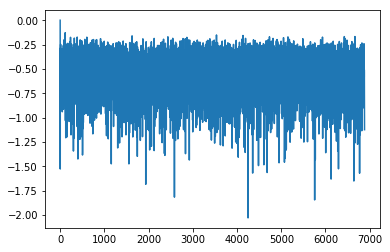

(6884, 1434)

In [11]:
import matplotlib.pyplot as plt
plt.plot(game_history)
plt.show()
len(game_history), len(agent.memory)

In [18]:
np.mean(game_history)
np.save('checkpoint52_dropout_gameHist',game_history)

Add survival reward into the model, such as if survive, then add another 20 points into the action?